In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

weather_data = pd.read_csv('london_weather.csv')
#weather_data = weather_data[['date', 'mean_temp']]
weather_data = weather_data.set_index('date', drop = True)
weather_data.index = pd.to_datetime(weather_data.index,format="%Y%m%d")
weather_data = weather_data.fillna(method='ffill')
weather_data.iloc[60]


cloud_cover              8.0
sunshine                 0.0
global_radiation        35.0
max_temp                12.6
mean_temp                6.8
min_temp                 1.6
precipitation            0.0
pressure            101640.0
snow_depth               0.0
Name: 1979-03-02 00:00:00, dtype: float64

In [2]:
values = weather_data.values
training_data_len = math.ceil(len(values)*0.8 )

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values)

#train_data = scaled_data[0: training_data_len, :]
#values = values.reshape(-1,1)
train_data = scaled_data[0: training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i])
    
x_train, y_train = np.array(x_train), np.array(y_train)

#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [3]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = scaled_data[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i])

x_test = np.array(x_test)
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [4]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(9))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           44000     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 9)                 234       
                                                                 
Total params: 127,159
Trainable params: 127,159
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopper = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,patience =3 ,verbose=1, mode='min')
model.fit(x_train, y_train, batch_size= 10, epochs=10, callbacks=early_stopper)

Epoch 1/10
1222/1222 [==============================] - 32s 24ms/step - loss: 0.0163
Epoch 2/10
1222/1222 [==============================] - 30s 25ms/step - loss: 0.0128
Epoch 3/10
1222/1222 [==============================] - 31s 25ms/step - loss: 0.0121
Epoch 4/10
1222/1222 [==============================] - 32s 26ms/step - loss: 0.0119
Epoch 5/10
1222/1222 [==============================] - 32s 26ms/step - loss: 0.0116
Epoch 6/10
1222/1222 [==============================] - 33s 27ms/step - loss: 0.0115
Epoch 7/10
1222/1222 [==============================] - 33s 27ms/step - loss: 0.0114
Epoch 8/10
1222/1222 [==============================] - 34s 27ms/step - loss: 0.0112
Epoch 9/10
1222/1222 [==============================] - 34s 28ms/step - loss: 0.0112
Epoch 10/10
1222/1222 [==============================] - 34s 28ms/step - loss: 0.0111


In [6]:
predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

96/96 [==============================] - 2s 15ms/step


0.009612974103896907

In [7]:
predictions = scaler.inverse_transform(predictions)


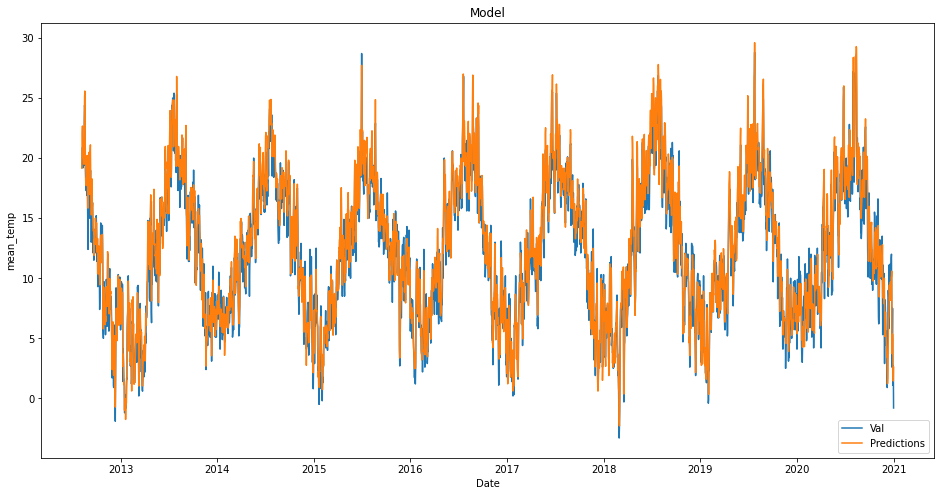

In [8]:
data = weather_data
train = data[:training_data_len]
validation = data[training_data_len:]
df = pd.DataFrame(predictions, columns = ['Pred_cloud_cover','Pred_sunshine','Pred_global_radiation','Pred_max_temp','Pred_mean_temp','Pred_min_temp','Pred_precipitation','Pred_pressure','Pred_snow_depth'])
df.index = validation.index
validation = pd.concat([validation,df],axis=1)
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('mean_temp')
#plt.plot(train)
plt.plot(validation[['mean_temp','Pred_mean_temp']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [10]:
# generate the multi-step forecasts
n_future = 365 
y_future = []

x_pred = x_test[-1:, :, :]  # last observed input sequence
y_pred = y_test[-1]         # last observed target value

for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1,1,9), axis=1)

    # generate the next forecast
    y_pred = model.predict(x_pred)

    # save the forecast
    y_future.append(y_pred)

# transform the forecasts back to the original scale
y_future = np.array(y_future).reshape(-1,9)
y_future = scaler.inverse_transform(y_future)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


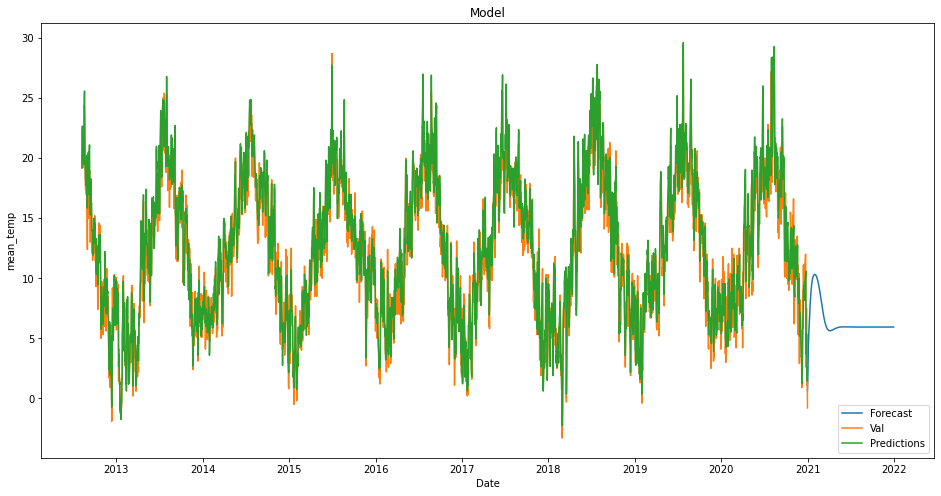

In [11]:
#df_future['Forecast'] = y_future.flatten()
df_future = pd.DataFrame(y_future, columns = ['Pred_cloud_cover','Pred_sunshine','Pred_global_radiation','Pred_max_temp','Pred_mean_temp','Pred_min_temp','Pred_precipitation','Pred_pressure','Pred_snow_depth'])
df_future['Date'] = pd.date_range(start='2020-12-31', periods=n_future)
df_future = df_future.set_index('Date')

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('mean_temp')
plt.plot(df_future['Pred_mean_temp'])
plt.plot(validation[['mean_temp', 'Pred_mean_temp']])
plt.legend(['Forecast','Val', 'Predictions'], loc='lower right')
plt.show()